Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Piotr Durniat"

In [2]:
import os
os.chdir("/root")

---

# 2. Grafowe sieci neuronowe

## Motywacja

### Geometric Deep Learning blueprint
W ramach wykładu wprowadziliśmy blueprint geometrycznego uczenia głębokiego. Jednym z podstawowych punktów tego opisu było założenie o lokalnie działających funkcjach ekwiwariantnych. W połączeniu z m.in. operacjami redukcji (*pooling*) można było zbudować model, który potrafi dobrze opisywać złożone zależności w danych.

W szczególności zauważyliśmy, że pojęcie lokalności w grafie jest oparte na definicji sąsiedztwa wierzchołków. Sąsiedztwem bezpośrednim $\mathcal{N}_u$ (1-skokowym; ang. *one hop neighborhood*) wierzchołka $u$ nazywamy:
$$\mathcal{N}_u = \{v \in \mathcal{V}: (u, v) \in \mathcal{E} \lor (v, u) \in \mathcal{E} \}$$

Lokalnie działająca funkcja $\phi(\mathbf{x}_u, \mathbf{X}_{\mathcal{N}_u})$, która wykorzystuje atrybuty danego wierzchołka $\mathbf{x}_u$ oraz cechy jego sąsiadów $\mathbf{X}_{\mathcal{N}_u}$, aby wyznaczyć wektor reprezentacji wierzchołka, pozwala na zbudowanie ekwiwariantnej względem permutacji funkcji $\mathbf{F}$:

$$
    \mathbf{F}(\mathbf{X}, \mathbf{A}) = 
        \begin{bmatrix}
            - \phi(\mathbf{x}_1, \mathbf{X}_{\mathcal{N}_1}) -\\
            - \phi(\mathbf{x}_2, \mathbf{X}_{\mathcal{N}_2}) -\\
            \vdots \\
            - \phi(\mathbf{x}_n, \mathbf{X}_{\mathcal{N}_n}) -\\
        \end{bmatrix}
$$

Połączenie wielu takich funkcji pozwala na opisanie szerszych sąsiedztw w grafie, tzn. połącznie dwóch warstw (funkcji) pozwala opisać sąsiedztwo dwu-skokowe (2-hop), połączenie trzech funkcji – 3-hop, itd. W trakcie obecnego laboratorium zobaczymy jak można zdefiniować funkcję $\phi$.

![](./assets/local_graph_function.png)
**Źródło**: M. M. Bronstein, J. Bruna, T. Cohen, P. Veličković, *Geometric Deep Learning: Grids, Groups, Graphs, Geodesics, and Gauges*


### Weisfeiler-Lehman kernel
Inną perspektywę na budowanie cech opisujących grafy poznaliśmy również na wykładzie, gdzie wprowadziliśmy algorytm kolorowania wierzchołków w celu zbadania izomorfizmu pary grafów. Na podstawie początkowo przypisanych kolorów wierzchołków, iteracyjnie każdy wierzchołek agregował multi-zbiór kolorów jego sąsiadów a następnie za pomocą funkcji haszującej $\text{HASH}$ obliczany był nowy kolor wierzchołka:

$$ c^{(k+1)}(v) = \text{HASH}(\{c^{(k)}(v), \{c^{(k)}(u)\}_{u \in \mathcal{N}(v)}\})$$

Powtórzenie tego kroku agregacji $K$-krotnie pozwalało opisać $K$-skokowe sąsiedztwo wierzchołków.


**Uwaga:** Zauważmy, że przeprowadzanie $K$ iteracji jest "równoważne" z połączeniem $K$-warstw (funkcji) z poprzedniego przykładu.

### Dodatkowe materiały
W przypadku chęci lepszego zrozumienia oraz uzupełnienia wiedzy dot. grafowych sieci neuronowych poleca się poniższe źródła:
- [(part 1) A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/)
- [(part 2) Understanding Convolutions on Graphs](https://distill.pub/2021/understanding-gnns/)
- Na dłuższą lekturę: [Graph Representation Learning (William L. Hamilton, 2020)](https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf)

W niniejszym zeszycie opiszemy i przeprowadzimy ewaluację 3 najpopularniejszych architektur grafowych sieci neuronowych, mianowicie:
- Graph Convolutional Network (**GCN**)
- Graph Sample and Aggregate (**GraphSAGE**)
- Graph Attention Network (**GAT**)

Wykorzystamy zbiór Cora i sprawdzimy jakość działania powyższych modeli w zadaniu klasyfikacji węzłów. Implementacje modeli są dostępne w bibliotece PyTorch-Geometric, natomiast do uczenia modeli wykorzystamy bibliotekę PyTorch-Lightning.

## 2.1. Załadowanie zbioru
Zbiory danych w PyTorch-Lightningu są przekazywane jako instancje obiektów `DataLoader` do metody `fit()` klasy `Trainer`. Można jednak użyć klasy `LightningDataModule` i w niej zdefiniować wszystkie data loadery wraz z wczytaniem właściwego zbioru. 

Zauważmy, że dotychczas rozważany zbiór danych Cora nie jest podzielony na mniejsze części (tj. mamy dokładnie jeden obiekt `Data`, który opisuje cały graf). Można wykorzystywać metody próbkowania grafów (np. `NeighborLoader`) i przez to uzyskać podział na mini-paczki, jednak zbiór Cora jest na tyle mały, że nie opłaca się go bardziej dzielić. 

Wykorzystamy natomiast fakt, że wczytywany obiekt `Planetoid` jest iterowalny i zwiera dokładnie jeden element. Możemy go zatem opakować w obiekt `DataListLoader` (dedykowana wersja `DataLoader`a zaimplementowana w PyTorch-Geometricu). W najnowszych wersjach PyG zaimplementowano dedykowaną klasę `LightningNodeData`, która przygotowuje grafy do przetwarzania przez modele w PyTorch-Lightningu.

**Proszę zapoznać się ze znaczeniem argumentów klasy `LightningNodeData`**.

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.data.lightning import LightningNodeData

dataset = Planetoid(root="./data", name="Cora")

datamodule = LightningNodeData(
    data=dataset[0],
    loader="full",
)

## 1.2. Trenowanie modeli
Wszystkie wymienione modele grafowych sieci neuronowych zostały zaproponowane jako warstwy (z perspektywy głębokiego uczenia maszynowego), które możemy połączyć z dowolnymi innymi warstwami, aby utworzyć model (tzn. możemy wykorzystać znane aktywacje, warstwy liniowe itd.). Istotne dla nas jest jednak to, że grafowe sieci neuronowe (ang. *Graph Neural Networks - GNN*) nie są związane z jakąkolwiek funkcją kosztu i możemy je uczyć zarówno w scenariuszu nadzorowanym jak i nienadzorowanym. Temat modeli nienadzorowanych jest bardziej złożony, zatem na razie go pominiemy i wrócimy do niego w następnym zeszycie.

Na chwilę obecną będziemy rozważać scenariusz nadzorowanej klasyfikacji wierzchołków. Przeanalizujmy implementację klasy `SupervisedNodeClassificationGNN`:

In [4]:
from IPython.display import Code, display

display(Code("src/supervised.py"))

from typing import Optional, Tuple

import pytorch_lightning as pl
import torch
from sklearn.metrics import roc_auc_score
from torch import nn
from torch_geometric.data import Data


class SupervisedNodeClassificationGNN(pl.LightningModule):
    """Supervised node classification for a given GNN model."""

    def __init__(self, gnn: nn.Module, emb_dim: int, num_classes: int):
        super().__init__()

        self._gnn = gnn
        self._classification_head = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(emb_dim, num_classes),
            nn.LogSoftmax(dim=1),
        )

        self._loss_fn = nn.NLLLoss()

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        return self._gnn(x, edge_index)

    def training_step(self, batch: Data, batch_idx: int) -> torch.Tensor:
        y_pred, y, auc = self._common_step(data=batch, mask=batch.train_mask)

        loss = self._loss_fn(input=y_pred, target=y)

        self.log("step", self.trainer.current_epoch)
        self.log("train/loss", loss.item(), on_epoch=True, on_step=False)
        self.log("train/auc", auc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch: Data, batch_idx: int):
        _, _, auc = self._common_step(data=batch, mask=batch.val_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("val/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def test_step(self, batch: Data, batch_idx: int):
        _, _, auc = self._common_step(data=batch, mask=batch.test_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("test/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def predict_step(
        self,
        batch: Data,
        batch_idx: int,
        dataloader_idx: Optional[int] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        z = self(batch.x, batch.edge_index)
        y = batch.y

        return z, y

    def _common_step(
        self,
        data: Data,
        mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, float]:
        z = self(data.x, data.edge_index)

        y_pred = self._classification_head(z)[mask]
        y = data.y[mask]

        auc = roc_auc_score(
            y_true=y.cpu(),
            y_score=y_pred.exp().detach().cpu(),
            multi_class="ovr",
        )

        return y_pred, y, auc

    def configure_optimizers(self):
        return torch.optim.AdamW(
            params=self.parameters(),
            lr=1e-3,
            weight_decay=5e-4,
        )

Jak już wspomnieliśmy modele grafowych sieci neuronowych mogą być stosowane w scenariuszu induktywnym. Pomimo, że przekazujemy pełną macierz atrybutów wierzchołków `data.x` oraz pełny zbiór krawędzi `data.edge_index`, funkcję kosztu oraz metrykę AUC obliczamy na wybranym pozbiorze wierzchołków. Podzbiór ten jest określany przez maskę zbioru treningowego `data.train_mask`, walidacyjnego `data.val_mask` oraz testowego `data.test_mask`. Na cele tego laboratorium możemy uznać taki scenariusz jako induktywny, jednak w rzeczywistych zastosowaniach musielibyśmy zadbać oto, aby na danym etapie uczenia (trening, walidacja, testowanie) pozostawiać tylko odpowiedni podzbiór krawędzi i wierzchołków.


In [5]:
# import sys
# sys.path.append("/root/src/")
from src.supervised import SupervisedNodeClassificationGNN

Dla wszystkich modeli zdefiniujmy sobie zbiór wspólnych hiperparametrów:

In [6]:
hparams = {
    "num_epochs": 10,
    "hidden_dim": 256,
    "emb_dim": 128,
}
ACCELERATOR = "cuda"  # change to "cuda" in order to use GPU

# 2.3. Graph Convolutional Network (GCN)
Grafowe sieci neuronowe po raz pierwszy w literaturze były proponowane już w okolicach 2008 roku, jednak dopiero rozwój i popularyzacja uczenia głębokiego pozwoliła na efektywne implementacje. Najpopularniejszym obecnie modelem grafowej sieci neuronowej jest **grafowa konwolucja** (GCN - *Graph Convolutional Network*), która została zaproponowana przez Kipfa w 2016 roku – [artykuł](https://arxiv.org/pdf/1609.02907.pdf). Praca ma już ponad 33 tysiące cytowań i wiele obecnych GNNów jest oparta na niej.

Model GCN w każdej warstwie oblicza nowe cechy wierzchołków $H^{(l+1)}$ na podstawie obecnych cech $H^{(l)}$ w następujący sposób:

$$H^{(l+1)} = \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)},$$
gdzie:
- $\hat{A} = A + I$ to macierz sąsiedztwa grafu z dołączonymi pętlami zwrotnymi na każdym wierzchołku (krawędź z danego wierzchołka do samego siebie)
- $\hat{D}$ to macierz stopnii węzłów (macierz diagonalna)
- $\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}$ to tzw. symetryczna normalizacja macierzy sąsiedztwa
- $W^{(l)}$ to macierz wyuczalnych parametrów

Powyższa funkcja odgrywa rolę wcześniej wprowadzonej funkcji $\phi$. Poprzez dodanie pętli na każdym wierzchołku, uśredniane są cechy zarówno sąsiadów jak i cechy danego wierzchołka. Natomiast symetryczna normalizacja pozwala uwzględnić stopień danego wierzchołka oraz stopień sąsiada.

Często definicja powyższej reguły *propagacji* uwzględnia również funkcję aktywacji. W celu uniknięcia pomyłek, tutaj ją pomijamy – PyTorch-Geometric też nie stosuje funkcji aktywacji w implementacjach poszczególnych warstw.

Zobaczmy jak zaimplementować grafową sieć neuronową wykorzystującą konwolucję grafową. Utworzymy sieć dwuwarstwową (uwzględniającą zatem sąsiedztwo dwu-skokowe) – zobacz klasa `GCNModel`. Następnie wykorzystamy klasę `SupervisedNodeClassificationGNN` i bibliotekę `PyTorch-Lightning`, aby nauczyć model klasyfikacji wierzchołków na zbiorze Cora.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | GCNModel   | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

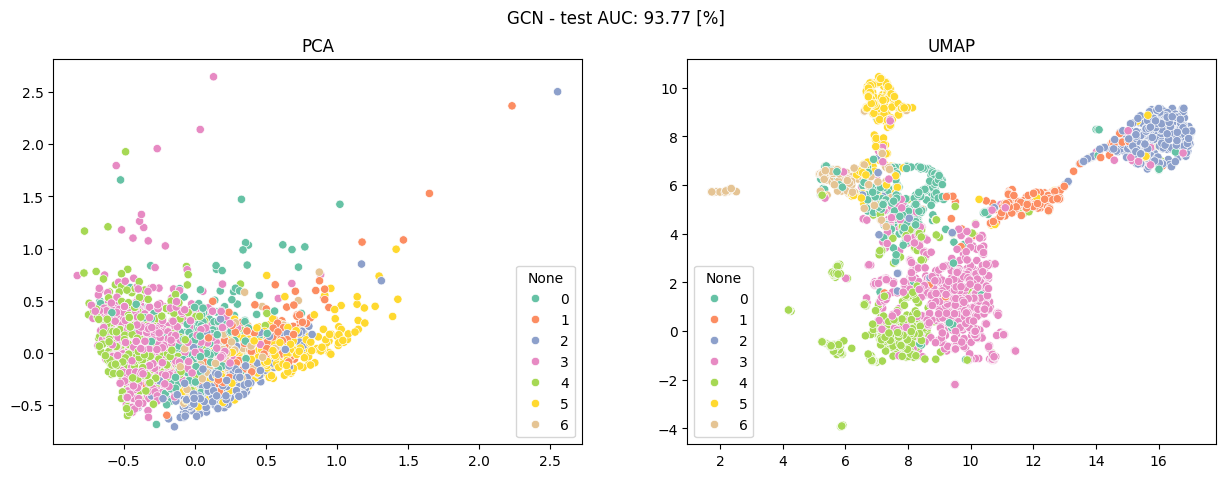

In [7]:
import matplotlib.pyplot as plt
from torch import nn
from torch_geometric.nn import GCNConv

from src.trainer import get_default_trainer
from src.utils import visualize_embeddings


class GCNModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


def evaluate_gcn():
    gnn = GCNModel(
        in_dim=datamodule.data.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )

    model = SupervisedNodeClassificationGNN(
        gnn=gnn,
        emb_dim=hparams["emb_dim"],
        num_classes=len(datamodule.data.y.unique()),
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_GCN",
        accelerator=ACCELERATOR,
    )

    trainer.fit(model=model, datamodule=datamodule)

    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0][
        "test/auc"
    ]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    z, y = z.cpu(), y.cpu()

    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"GCN - test AUC: {test_auc * 100.:.2f} [%]")

    plt.show()


evaluate_gcn()

## 2.4. Graph Sample and Aggregate (GraphSAGE)
W 2017 roku Hamilton opublikował [pracę](https://arxiv.org/pdf/1706.02216.pdf), w której rozważał induktywne uczenie grafowych sieci neuronowych oraz zaproponował sposób na osiągnięcie lepszej skalowalności metod GNNowych. Zaproponowana metoda (a właściwie rodzina metod) opiera się na idei próbkowania sąsiedztwa grafu (losowo wybrany podzbiór sąsiadów danego węzła) i następnie agregacji cech tak uzyskanej próbki sąsiadów. Zostały rozważone 3 metody agregacji: uśrednienie, LSTM oraz max pooling. Metoda była inspirowana bezpośrednio algorytmem Weisfeiler-Lehman test, a reguła propagacji jest zdefiniowana następująco (z perspektywy pojedynczego wierzchołka):

$$h^{(l)}_{\mathcal{N}(u)} = \text{AGGREGATE}^{(l)}(\{h^{(l)}_v, \forall v\in\mathcal{N}(u) \}) $$
$$h^{(l+1)}_u = W^{(l)} \cdot \text{CONCAT}(h^{(l)}_u, h^{(l)}_{\mathcal{N}(u)})$$

Widzimy zatem, że najpierw agregujemy cechy sąsiadów za pomocą wybranej metody agregacji, a następnie konkatenujemy wektor cech danego wierzchołka ze zagregowanym wektorem sąsiadów, po czym przemnażamy taki wektor przez macierz wag.

W PyTorch-Geometricu, metoda GraphSAGE (tutaj: `SAGEConv`) jest zaimplementowana delikatnie inaczej – reguła propagacji jest określona następująco (dla wariantu z uśrednieniem):

$$h^{(l+1)}_u = W^{(l)}_1 \cdot h^{(l)}_u + W^{(l)}_2 \cdot \text{mean}_{v\in\mathcal{N}(u)} h^{(l)}_v$$

Cechy danego wierzchołka i zagregowanego sąsiedztwa są przekształcane przez osobne wyuczalne macierze.

Analogicznie do modelu GCN przeprowadźmy ewaluację:

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type           | Params
--------------------------------------------------------
0 | _gnn                 | GraphSAGEModel | 799 K 
1 | _classification_head | Sequential     | 17.4 K
2 | _loss_fn             | NLLLoss        | 0     
--------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.268     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

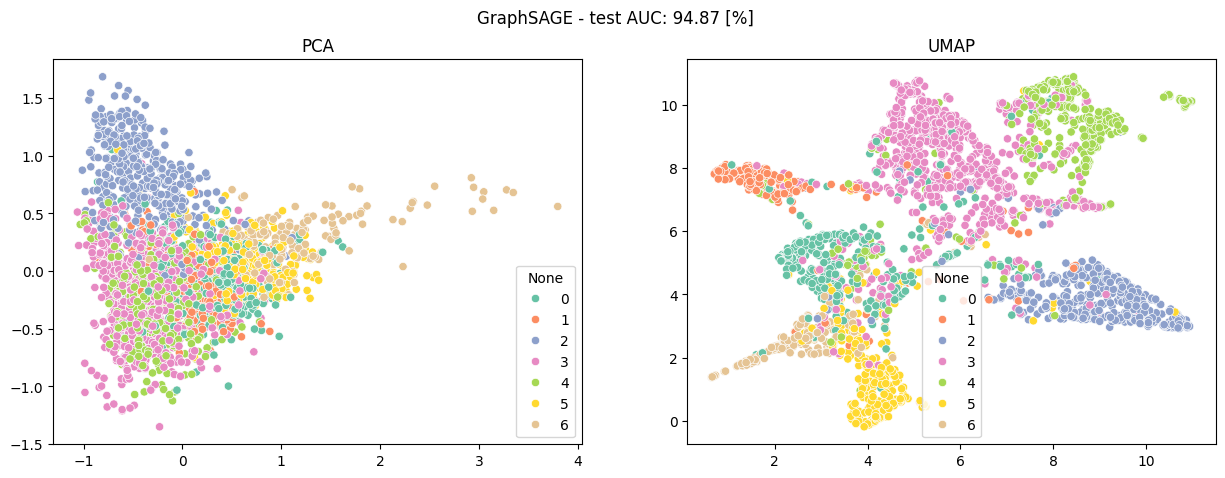

In [8]:
from torch_geometric.nn import SAGEConv


class GraphSAGEModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


def evaluate_graphsage():
    gnn = GraphSAGEModel(
        in_dim=datamodule.data.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )

    model = SupervisedNodeClassificationGNN(
        gnn=gnn,
        emb_dim=hparams["emb_dim"],
        num_classes=len(datamodule.data.y.unique()),
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_GraphSAGE",
        accelerator=ACCELERATOR,
    )

    trainer.fit(model=model, datamodule=datamodule)

    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0][
        "test/auc"
    ]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    z, y = z.cpu(), y.cpu()

    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"GraphSAGE - test AUC: {test_auc * 100.:.2f} [%]")

    plt.show()


evaluate_graphsage()

## 2.5. Graph Attention Network (GAT)
Również w 2017 roku, Velickovic opublikował [pracę](https://arxiv.org/pdf/1710.10903.pdf), która przetłumaczyła mechanizm uwagi znany z przetwarzania języka naturalnego do dziedziny grafów. Powstała metoda nazywana Graph Attention (GAT). Reguła propagacji jest określona następująco:

$$h^{(l+1)}_u = \alpha_{u,u} W^{(l)}h^{(l)}_u + \sum_{v \in \mathcal{N}(u)} \alpha_{u,v}W^{(l)}h^{(l)}_v $$

$$\alpha_{i, j} = \frac{\exp(\text{LeakyReLU}(a^T[W^{(l)}h^{(l)}_i || W^{(l)}h^{(l)}_j]))}{\sum_{k\in i\cup \mathcal{N}(i)} \exp(\text{LeakyReLU}(a^T[W^{(l)}h^{(l)}_i || W^{(l)}h^{(l)}_k]))},$$

gdzie:
- $W^{(l)}$ to wyuczalna macierz parametrów
- $a$ to wyuczalne parametry mechanizmu uwagi (ang. *attention parameters*)
- $\alpha$ to współczynniki mechanizmu uwagi (ang. *attention coefficients*)

Metoda pozwala również na wykorzystanie wielu głowic uwagi (ang. *multi-headed attention*).

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | GATModel   | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.673     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

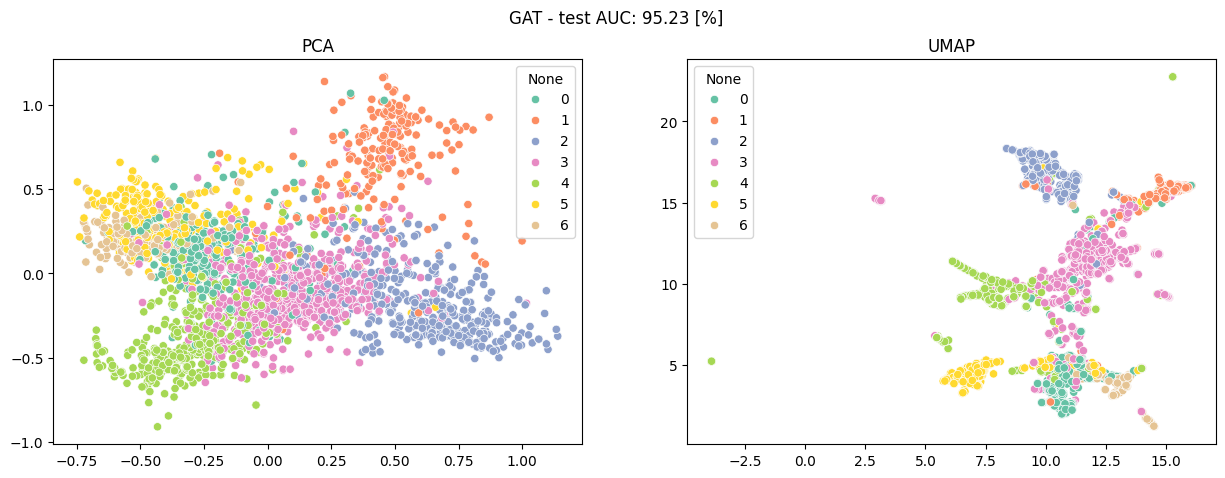

In [9]:
from torch_geometric.nn import GATConv


class GATModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=1)
        self.act1 = nn.ReLU()
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


def evaluate_gat():
    gnn = GATModel(
        in_dim=datamodule.data.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )

    model = SupervisedNodeClassificationGNN(
        gnn=gnn,
        emb_dim=hparams["emb_dim"],
        num_classes=len(datamodule.data.y.unique()),
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_GAT",
        accelerator=ACCELERATOR,
    )

    trainer.fit(model=model, datamodule=datamodule)

    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0][
        "test/auc"
    ]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    z, y = z.cpu(), y.cpu()

    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"GAT - test AUC: {test_auc * 100.:.2f} [%]")

    plt.show()


evaluate_gat()

In [10]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs --port 6006

# Zadania
---

## Zadanie 2.1. Opis i ewaluacja wybranej warstwy GNN (3 pkt)
Korzystając z listy zaimplementowanych w PyTorch-Geometricu warstw grafowych sieci neuronowych, wybierz jedną z nich, a następnie:

a) Sprawdź jak w tej warstwie realizowana jest reguła propagacji – porównaj wzór z wyżej badanymi modelami oraz zastanów się jak rozumiesz zasadę działania. **Na zajęciach, powinieneś potrafić to wyjaśnić własnymi słowami.**

b) Analogicznie do modeli GCN, GraphSAGE oraz GAT, zaimplementuj model dwuwarstwowy i przeprowadź jego ewaluację w zadaniu nadzorowanej klasyfikacji wierzchołków.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type             | Params
----------------------------------------------------------
0 | _gnn                 | SelectedGNNModel | 1.6 M 
1 | _classification_head | Sequential       | 17.4 K
2 | _loss_fn             | NLLLoss          | 0     
----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.465     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

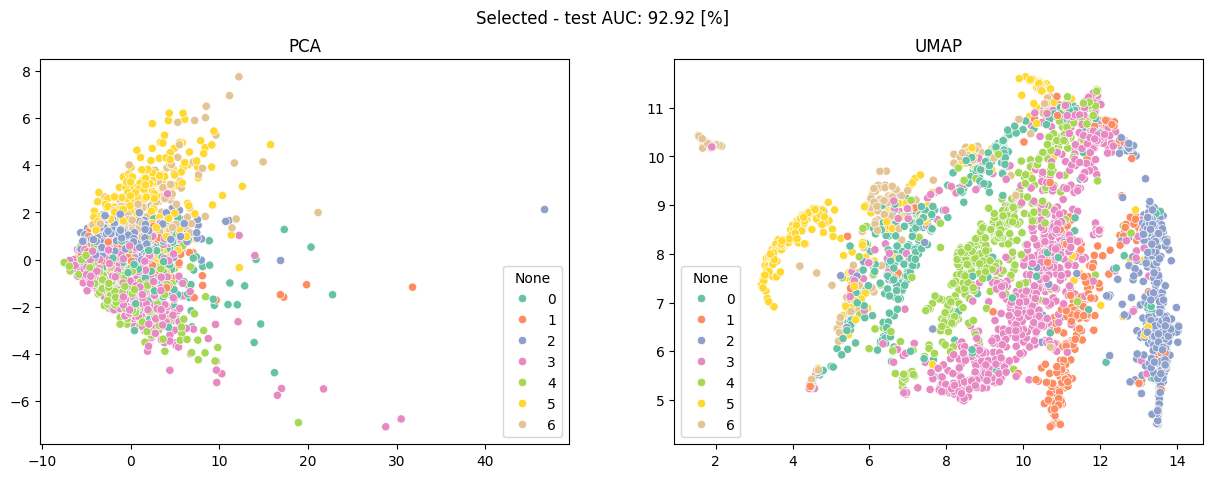

In [11]:
from torch_geometric.nn import ChebConv


class SelectedGNNModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int, K: int = 4):
        super().__init__()
        # TU WPISZ KOD
        self.conv1 = ChebConv(in_dim, hidden_dim, K)
        self.act1 = nn.ReLU()
        self.conv2 = ChebConv(hidden_dim, out_dim, K)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        # TU WPISZ KOD
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


def evaluate_selected_gnn():
    gnn = SelectedGNNModel(
        in_dim=datamodule.data.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )

    model = SupervisedNodeClassificationGNN(
        gnn=gnn,
        emb_dim=hparams["emb_dim"],
        num_classes=len(datamodule.data.y.unique()),
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_Selected",
        accelerator=ACCELERATOR,
    )

    trainer.fit(model=model, datamodule=datamodule)

    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0][
        "test/auc"
    ]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    z, y = z.cpu(), y.cpu()

    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"Selected - test AUC: {test_auc * 100.:.2f} [%]")

    plt.show()


evaluate_selected_gnn()

## Zadanie 2.2. Badanie głębokości grafowej sieci neuronowej (5 pkt)
a) Dla trzech powyżej przedstawionych modeli GNNowych oraz wybranej w zadaniu 2.1 warstwy, zaimplementuj klasę, która utworzy grafową sieci neuronową z dowolnie określoną liczbą warstw (w poprzednich przykładach używaliśmy 2-warstowego GNNa) zadanego typu.

b) Zbadaj jak głębokość grafowej sieci neuronowej wpływa na jakość uzyskiwanych reprezentacji (uwzględniając miarę AUC na zbiorze testowym). Wybierz kilka wartości dla liczby warstw i przedstaw wyniki w tabelce. Pamiętaj aby każdy eksperyment powtórzyć kilkukrotnie i podać wynik uśredniony wraz z odchyleniem standardowym. Skomentuj wyniki.

c) Jak nazywa się to zaobserwowane zjawisko i wytłumacz własnymi słowami na czym polega. 

In [19]:
import pandas as pd
import torch
import torch.nn as nn


class NLayerGNN(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        layer_name: str,
        num_layers: int,
    ):
        super().__init__()

        # TU WPISZ KOD
        self.num_layers = num_layers
        self.act = nn.ReLU()
        self.conv1 = self._make_layer(layer_name, in_dim, hidden_dim)
        for i in range(2, num_layers):
            setattr(
                self, f"conv{i}", self._make_layer(layer_name, hidden_dim, hidden_dim)
            )
        setattr(
            self, f"conv{num_layers}", self._make_layer(layer_name, hidden_dim, out_dim)
        )

    @staticmethod
    def _make_layer(layer_name: str, in_dim: int, out_dim: int):
        # TU WPISZ KOD
        if layer_name == "gcn":
            return GCNConv(in_dim, out_dim)
        elif layer_name == "sage":
            return SAGEConv(in_dim, out_dim)
        elif layer_name == "gat":
            return GATConv(in_dim, out_dim, heads=1)
        elif layer_name == "cheb":
            return ChebConv(in_dim, out_dim, K=3)
        else:
            raise ValueError("Wrong layer_name")

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        # TU WPISZ KOD
        for i in range(1, self.num_layers + 1):
            conv_layer = getattr(self, f"conv{i}")
            x = self.act(conv_layer(x, edge_index))
        return x


def evaluate_num_layers():
    # GCN
    df, z_list, y_list, num_layers_list = get_mean_auc("gcn")
    print("GCN:")
    display(df)
    plot_representations(z_list, y_list, df.test_auc.values)

    # SAGE
    df, z_list, y_list, num_layers_list = get_mean_auc("sage")
    print("sage:")
    display(df)
    plot_representations(z_list, y_list, df.test_auc.values)

    # GAT
    df, z_list, y_list, num_layers_list = get_mean_auc("gat")
    print("gat:")
    display(df)
    plot_representations(z_list, y_list, df.test_auc.values)

    # CHEB
    df, z_list, y_list, num_layers_list = get_mean_auc("cheb")
    print("cheb:")
    display(df)
    plot_representations(z_list, y_list, df.test_auc.values)


def evaluate_layer(layer_name: str, num_layers: int):
    # TU WPISZ KOD
    gnn = NLayerGNN(
        in_dim=datamodule.data.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
        layer_name=layer_name,
        num_layers=num_layers,
    )

    model = SupervisedNodeClassificationGNN(
        gnn=gnn,
        emb_dim=hparams["emb_dim"],
        num_classes=len(datamodule.data.y.unique()),
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_Selected",
        accelerator=ACCELERATOR,
        quiet=True,
    )

    trainer.fit(model=model, datamodule=datamodule)

    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0][
        "test/auc"
    ]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    z, y = z.cpu(), y.cpu()

    return z, y, test_auc


LAYER_COUNTS = [2, 5, 20]

def get_mean_auc(
    layer_type: str, N: int = 20
):
    scores = []
    z_list = []
    y_list = []

    for num_layers in LAYER_COUNTS:
        score = 0
        for _ in range(N):
            z, y, test_auc = evaluate_layer(layer_type, num_layers)
            score += test_auc
        mean_score = score / N
        scores.append(mean_score)
        z_list.append(z)
        y_list.append(y)

    df = pd.DataFrame({"layer count": LAYER_COUNTS, "test_auc": scores})
    return df, z_list, y_list, LAYER_COUNTS


def plot_representations(
    z_list: list[float],
    y_list: list[float],
    scores: list[float],
):
    for i, layer_count in enumerate(LAYER_COUNTS):
        fig = visualize_embeddings(z=z_list[i], y=y_list[i])
        fig.suptitle(
            f"Selected - test AUC: {scores[i] * 100.:.2f} [%] for {layer_count} convolutional layers"
        )
        plt.show()

GCN:


,layer count,test_auc
0,2,0.945243
1,5,0.925612
2,20,0.720795


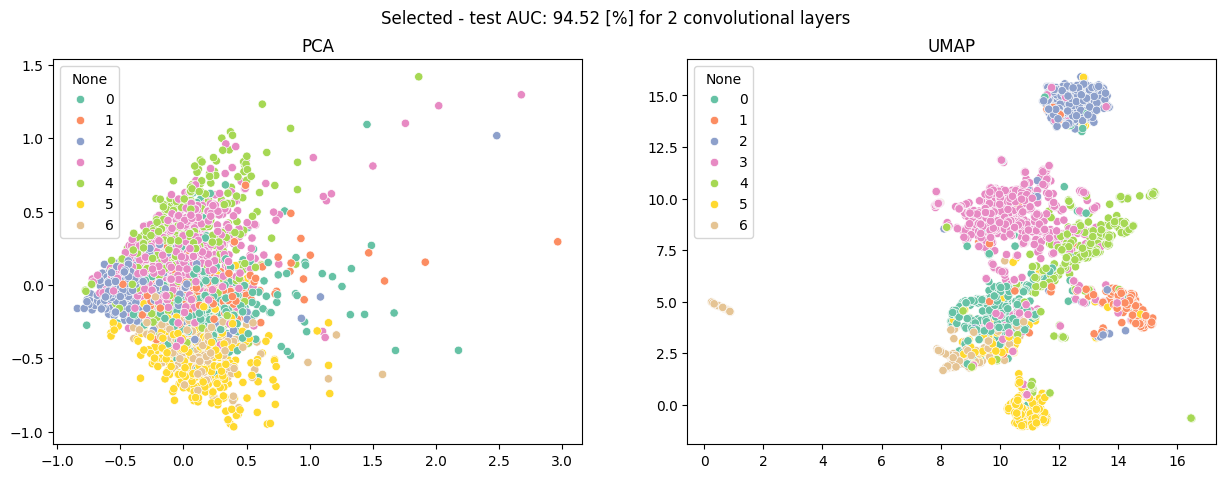

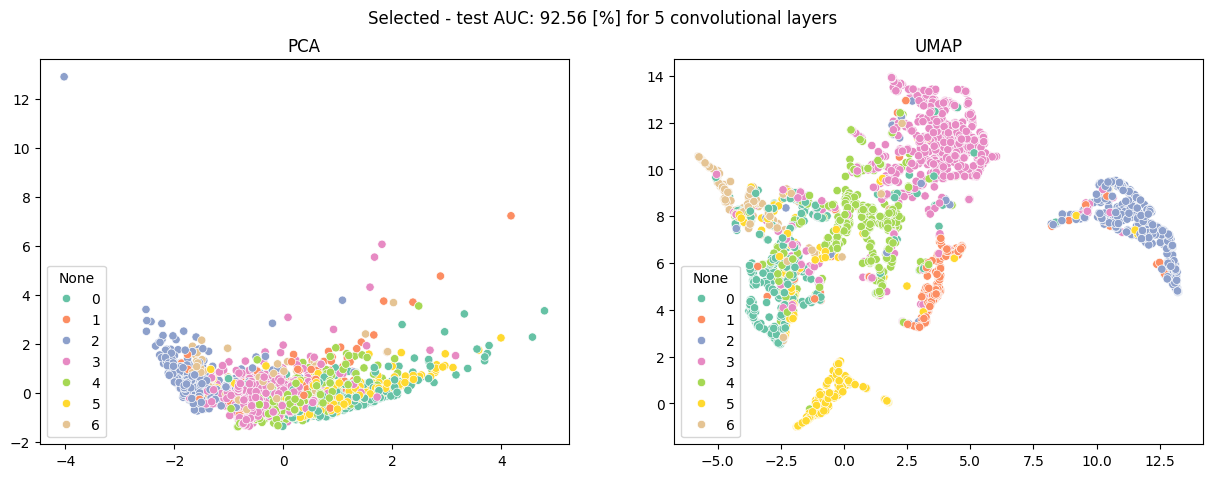

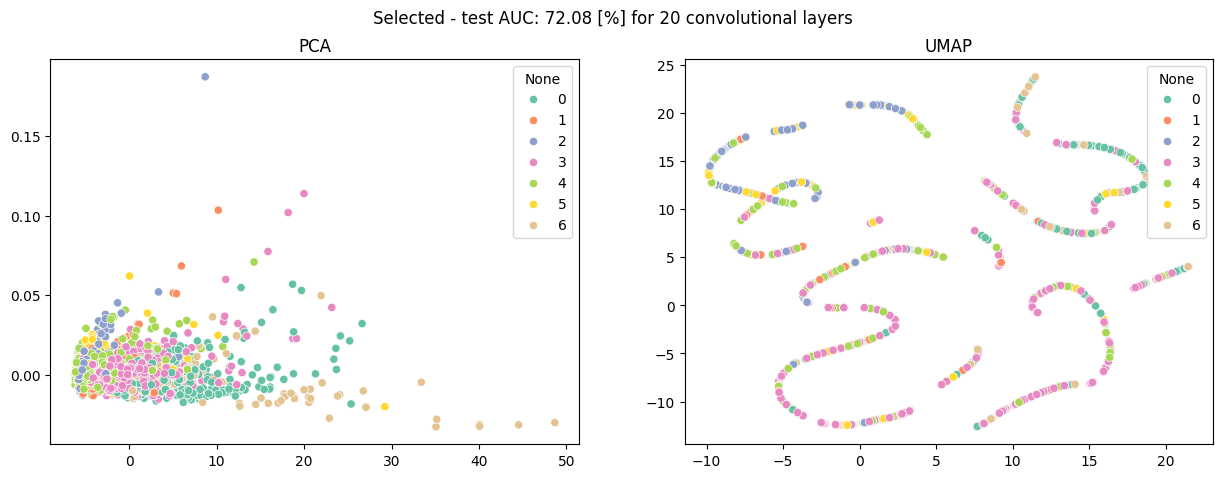

sage:


,layer count,test_auc
0,2,0.941304
1,5,0.917019
2,20,0.689268


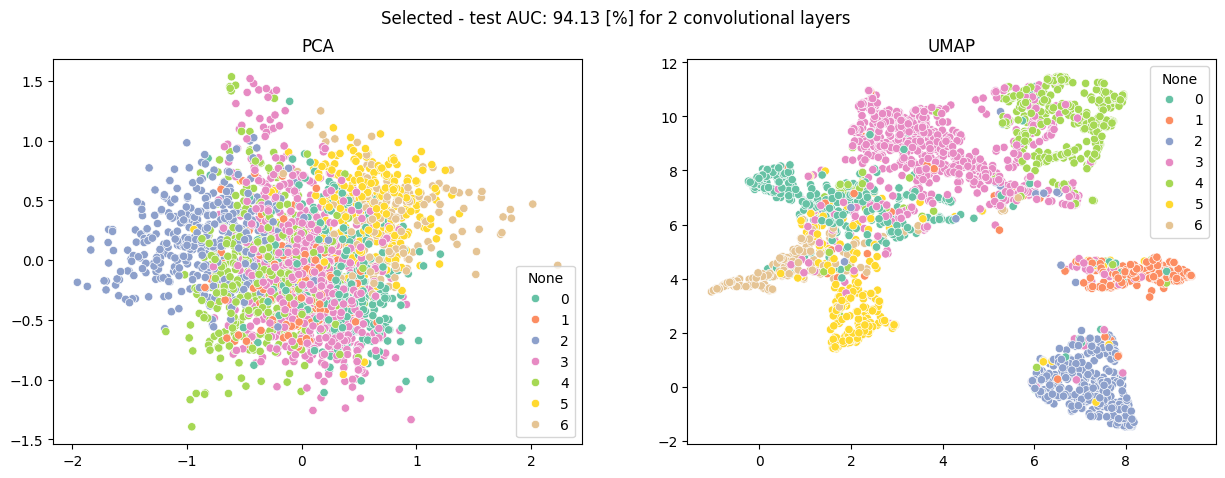

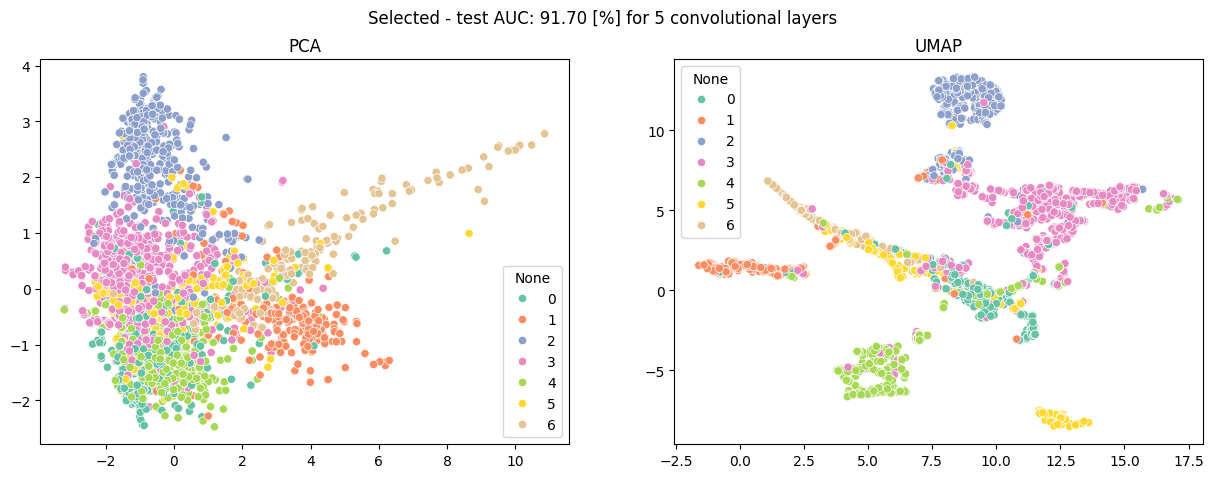

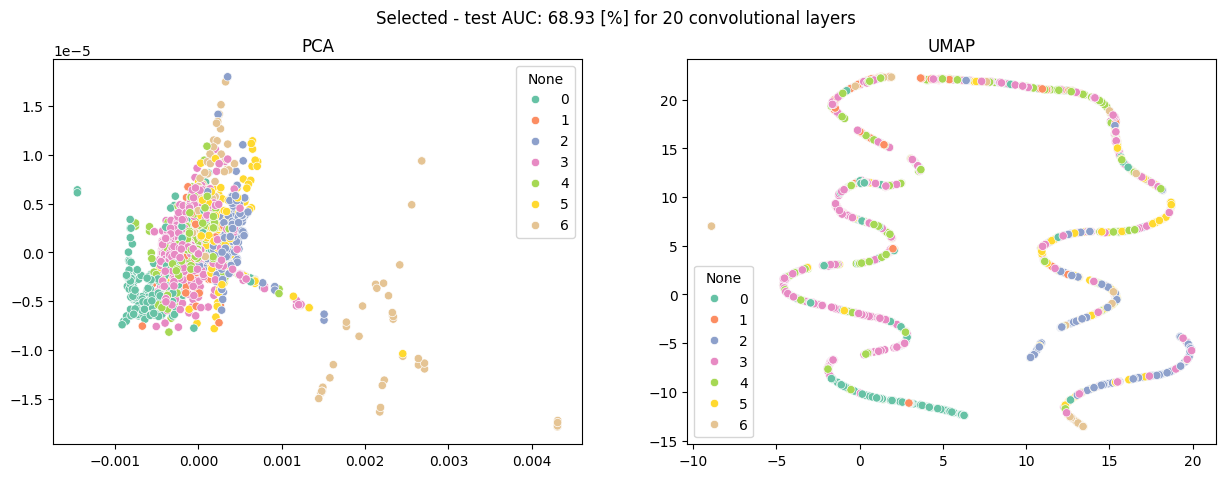

gat:


,layer count,test_auc
0,2,0.948248
1,5,0.926888
2,20,0.702409


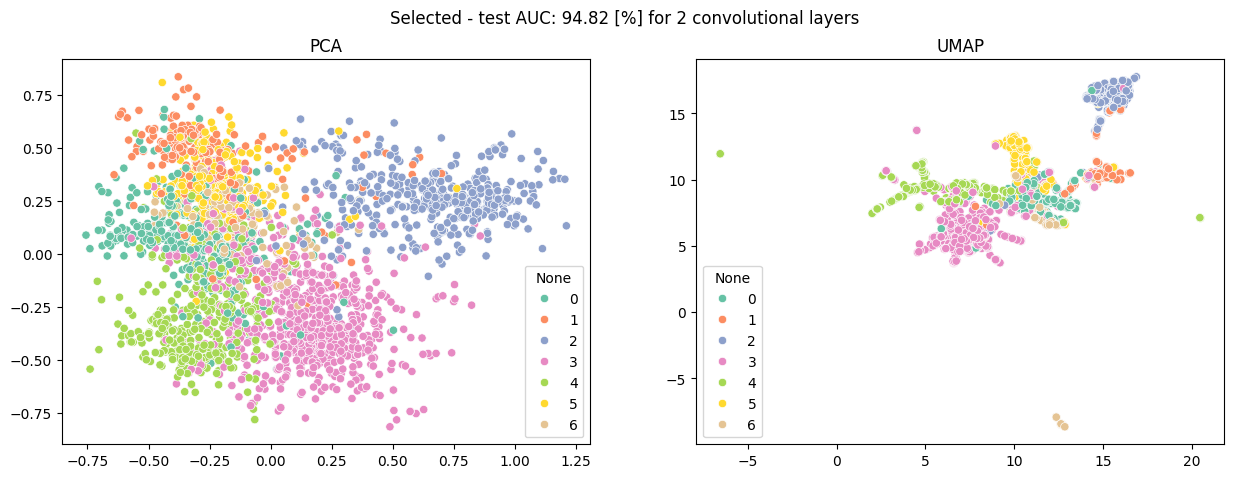

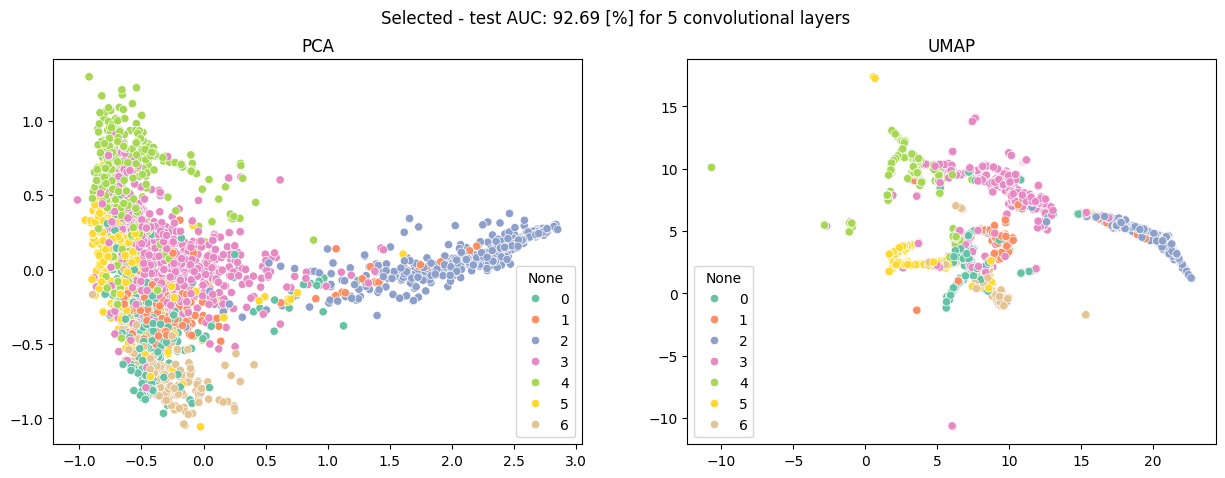

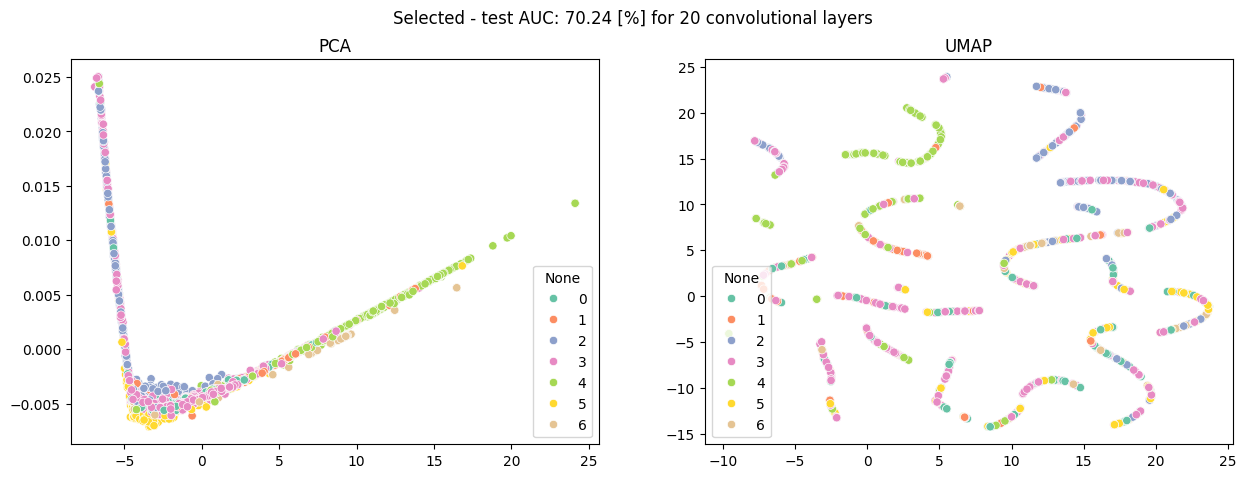

cheb:


,layer count,test_auc
0,2,0.934208
1,5,0.943632
2,20,0.548974


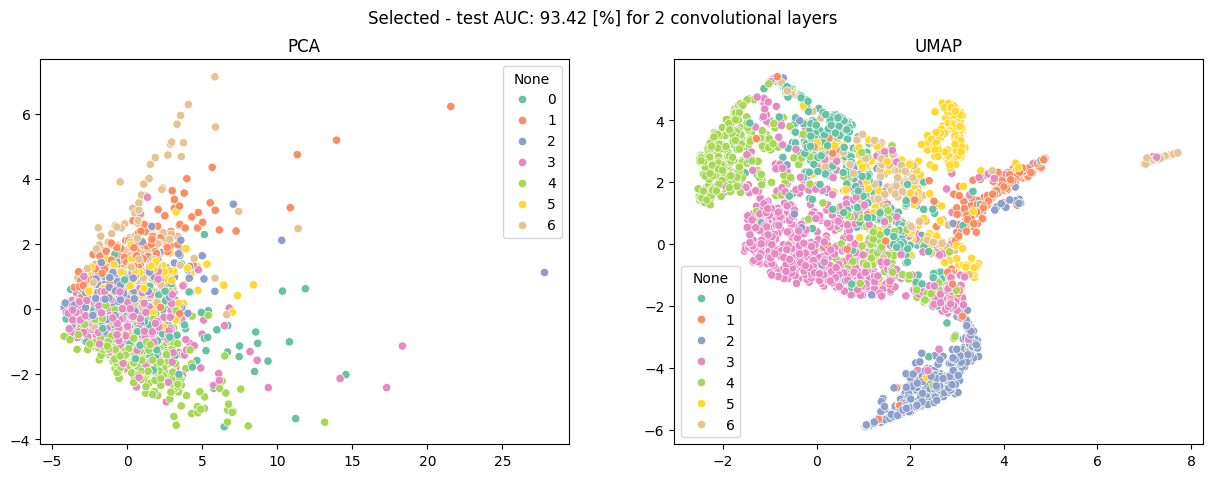

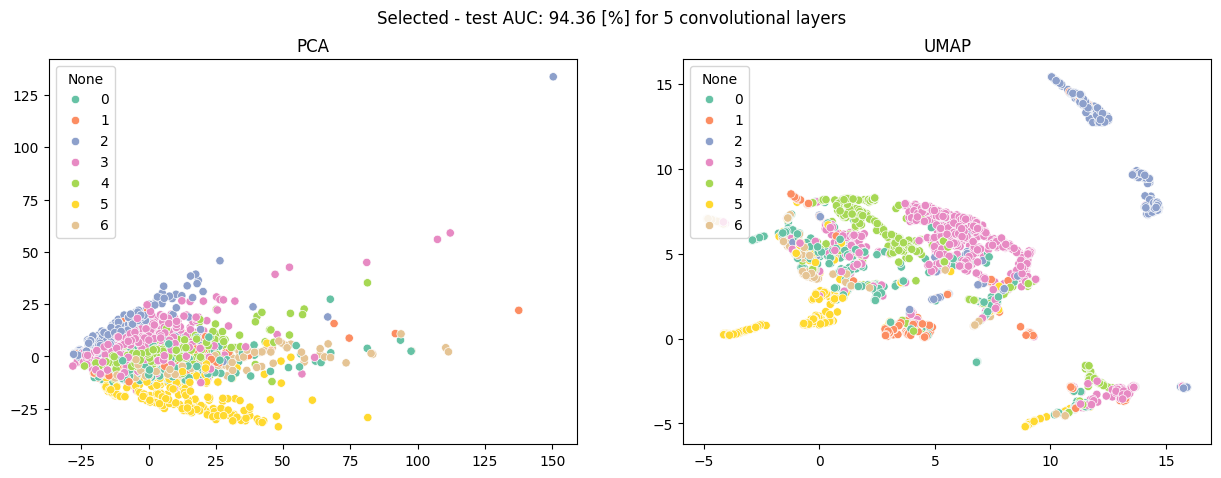

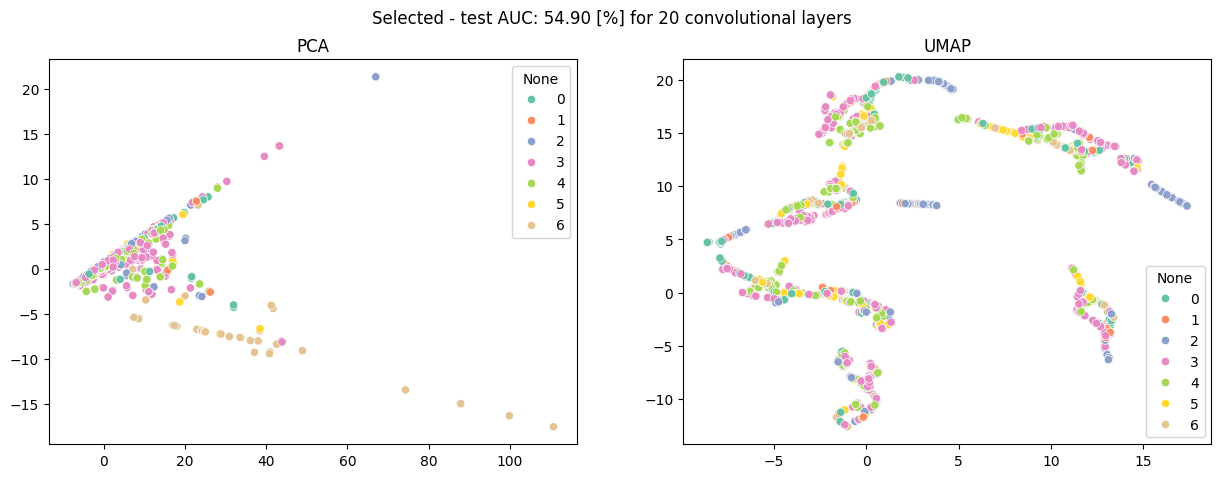

In [20]:
evaluate_num_layers()